In [1]:
## Not sure what I'm doing

import numpy as np
import pandas as pd
import pickle
from itertools import combinations
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import wasserstein_distance
from scipy.stats import energy_distance
import warnings
import statistics

import sys
sys.path.append('/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/v0.analysis/scripts/pythonScripts/functions/')
from utils import flatten

## Set up. 
dataDir = '/gpfs/commons/groups/gursoy_lab/ajoglekar/Projects/2023_03_01_multiwayInteractions/2023_03_01_v0_dataGathering/v0_hypergraphSimulations/getMultiwayInteractions_fromBPChains/'
runDir = 'v2.evaluateExpectedVersusInteresting_sample2/'
plotDir = f'{dataDir}{runDir}Plots_sample2_10kChains_500_750_1/'
outDir = f'{dataDir}{runDir}dfs_sample2_10kChains_500_750_1/'

In [2]:
numFiles = 10000
with open(f'{dataDir}v2.makeCombinedHypergraphDicts/sample2/hyperEdges_1_500_750_final_chains.pkl','rb') as f:
    hpEdges = pickle.load(f)

# numEdges = np.loadtxt(f'{dataDir}makeHyperGraphDict/numEdges_3_600_750_{numFiles}_chains.txt')

In [3]:
hpKeys = [k for k in hpEdges.keys()]
hpKeys_split = [k.split("_") for k in hpEdges.keys()]
keyCard = [len(item) for item in hpKeys_split]

In [16]:
print("Processing all the hyperedges from pickle file")
hpKeys = [k for k in hpEdges.keys()]
print("A total of",len(hpKeys),"initial interactions")
#keyCard = [len(item) for item in hpKeys_split]

readSupport = [v[0] for v in hpEdges.values()]
chainSupport = [v[1] for v in hpEdges.values()]
readCards = [v[3] for v in hpEdges.values()]

atLeastTwoChains = [i for i,x in enumerate(chainSupport) if x >=2]
updatedDict = {hpKeys[i]:readSupport[i] for i in atLeastTwoChains}

hpKeys = [k for k in updatedDict.keys()]
hpKeys_split = [k.split("_") for k in updatedDict.keys()]
keyCard = [readCards[i] for i in atLeastTwoChains]
hpEdges = updatedDict

print("Updated the input: retaining",len(hpKeys),
    "interactions with chain support of at least 2")

Processing all the hyperedges from pickle file
A total of 5371539 initial interactions
Updated the input: retaining 1928433 interactions with chain support of at least 2


## Functions

In [85]:
def getPairwiseDist(combination):
    """Given a two-way interaction, find dist between them"""
    ends = [int(combination[i].split(":")[1]) for i in [0,1]]
    diff = (ends[1] - ends[0]) / 5
    return(diff)

def getNWayMeanDistPerSubset(comb):
    """Get the mean pairwise distance given a
    high cardinality read"""
    twoWays = list(combinations(comb,2))
    twoWayDist = [getPairwiseDist(c) for c in twoWays]
    meanDist = round(statistics.mean(twoWayDist))
    return(meanDist)

def makeNWayDict(ix,hpEdges,hpKeys_split,n):
    """For a high cardinality read, make a dictionary
    that outputs the frequency and mean distance for subsets
    of cardinality n"""
    splitKey = hpKeys_split[ix]
    combs = list(combinations(splitKey,n))
    subsetDict = defaultdict(int)
    for comb in combs:
        subsetEdge = '_'.join(map(str, comb))
        try:
            subsetEdgeReads = hpEdges[subsetEdge]
        except KeyError:
            subsetEdgeReads = 0
        meanDist = getNWayMeanDistPerSubset(comb)
        subsetDict[meanDist] = subsetEdgeReads
    return(subsetDict)

def getProbabilitiesByDist(mainDict):
    """Get probabilities of reads occurring by mean dist to
    obtain the expected probability distribution from the data"""
    totalReadsForCard = sum(mainDict.values())
    print("Total=",totalReadsForCard)
    normalized_values = [value / totalReadsForCard for value in mainDict.values()]
    return(normalized_values)

def getNWayProbsPerCard(card,hpEdges,keyCard,hpKeys_split,n,toPlot):
    """Get distance-stratified expected probability distribution for high
    cardinality reads and their subsets of cardinality n"""
    ixList = [index for index,element in enumerate(keyCard) if element == card]
    mainDict = defaultdict(int)

    for ix in ixList:
        nWayDict = makeNWayDict(ix,hpEdges,hpKeys_split,n)
        for key in nWayDict.keys():
            mainDict[key] += nWayDict[key]

    normalized_values = getProbabilitiesByDist(mainDict)
    if toPlot is True:
        plotReadFreqsPerCard(mainDict,normalized_values,card,n)
    
    probabilityDict = {list(mainDict.keys())[ix]:normalized_values[ix] for ix in range(len(normalized_values))}
    return(probabilityDict)

def makeAllReferenceHashDicts(keyCard,hpEdges,hpKeys_split):
    """For all available cards, create look up table of probability of
    seeing all possible subsets as a function of mean distances
    between subsets"""
    probHash = defaultdict(dict)

    for card in range(max(keyCard),2,-1):
        print("Calculating for card=",card)
        ixList = [index for index,element in enumerate(keyCard) if element == card]
        print("There are ",len(ixList),"reads")
        for n in range(2,card):
            print(f"Creating a probability hash for {n}-way subsets")
            hashID = f'{card}sub{n}'
            probHash[hashID] = getNWayProbsPerCard(card,hpEdges,keyCard,hpKeys_split,n,True)
    return(probHash)

def plotReadFreqsPerCard(mainDict,normalized_values,card,n):
    """Takes in a generated dictionary and plots the
    read frequency as well as probabilities (first 20) by the
    distance"""

    # Step 1: Plot a barplot with dictionary keys on the x-axis and values on the y-axis
    sns.barplot(x=list(mainDict.keys()), y=list(mainDict.values()),color = "grey")
    plt.title(f"Read frequency of {n}-way subsets for Card={card}")
    plt.xlabel(f"Mean distance between {n}-way interactions")
    plt.ylabel("Frequency")
    plt.xticks(rotation=90,fontsize=5)
    plt.savefig(f'{plotDir}DistStratProbs_Card{card}sub{n}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()

    # Step 2: Plot the same barplot with the ratio of each value to the total
    sns.barplot(x=list(mainDict.keys()), y=normalized_values,color = "grey")
    plt.title(f"Probability of occurrence {n}-way distance for Card={card}")
    plt.xlabel(f"Mean distance between {n}-way interactions")
    plt.ylabel("Probabilities")
    plt.xlim(0,19)
    plt.xticks(rotation=90)
    plt.savefig(f'{plotDir}DistStratProbs_top20_Card{card}sub{n}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()
    plt.close()
    return None

def getReadExpectednessStats(card,ix,hpKeys_split,n,expHash,toPlot):
    """Per read, get the observed distribution of n-way contacts
    and calculate similarity to the expected distribution"""
    readDict = makeNWayDict(ix,hpEdges,hpKeys_split,n)
    readPercs = getProbabilitiesByDist(readDict)
    probVals = [expHash[k] for k in readDict.keys()]
    normProbs = [p / sum(probVals) for p in probVals]
    if toPlot is True:
        if len(readPercs) > 2 and len(probVals) > 2:
            makeSanityCheckPlotsPerRead(readDict,readPercs,probVals,card,n)
    #correlation = np.corrcoef(readPercs, probVals)[0, 1]
    similarity = cosine_similarity(np.array(readPercs).reshape(1,-1), 
                                np.array(probVals).reshape(1,-1))[0,0]
    wDist = wasserstein_distance(readPercs, probVals)
    empDist = calcEmpDist(readPercs, probVals)
    return(wDist, similarity, empDist)

def calcEmpDist(readPercs, probVals):
    """Trying a different metric for distance. 
    We will figure out the cutoff later"""
    obs = np.log(readPercs)
    exp = np.log(probVals)
    obsOverExp = obs/exp
    meanOE = obsOverExp.mean()
    return(meanOE)

def getStatsPerCard(card,n,probHash,toChoose,toPlot,revised_ixes):
    """Per cardinality, get a subset of reads (for computational
    purposes), calculate the correlation of observed n-way interactions
    to the expected value, and output a list"""
    corrList = []
    cosList = []
    expHash = f'{card}sub{n}'
    for ix in revised_ixes:
        #print(ix)
        corr, cos = getReadExpectednessStats(card,ix,hpKeys_split,n,probHash[expHash],toPlot)
        corrList.append(corr)
        cosList.append(cos)
    return(corrList, cosList)

def statsForAllCardSubsets(card,probHash,toChoose,toPlot,seed):
    """Wrapper for the stats per card. Calculates for all subsets of a card and binds into a df"""
    print("Calculating for card=",card)
    ixList = [index for index,element in enumerate(keyCard) if element == card]
    print("There are ",len(ixList),"reads")
    toChoose = min(toChoose,len(ixList))
    print("Calculating stats for",toChoose,"reads")
    random.seed(seed)
    revised_ixes = random.sample(ixList,toChoose)
    C1 = []
    C2 = []
    for n in range(2,card):
        print("Subset = ",n)
        stats = getStatsPerCard(card,n,probHash,toChoose,toPlot,revised_ixes)
        C1.append(stats[0])
        C2.append(stats[1])
    cN = [str(card)+"Sub"+str(i) for i in range(2,card)]
    df1 = pd.DataFrame(C1).T
    df2 = pd.DataFrame(C2).T
    df1.columns = cN
    df2.columns = cN
    df1['Edge_ix'] = revised_ixes
    df2['Edge_ix'] = revised_ixes
    return(df1,df2)

def getCutoff(summaryDF,quartile):
    q = f'{quartile}%'
    cutoff = pd.Series(summaryDF['mean']).describe()[q]
    return(cutoff)

def statsForAllReads(keyCard,probHash,toChoose,toPlot,plotScatter,seed):
    """Wrapper for all reads"""
    for card in range(max(keyCard),3,-1):
        corrStats, cosStats = statsForAllCardSubsets(card,probHash,toChoose,toPlot,seed)
        summaryCos = cosStats.filter(like="Sub").agg((np.mean,np.std),axis = 1)
        summaryCorr = corrStats.filter(like="Sub").agg((np.mean,np.std),axis = 1)
        cosCutoff = getCutoff(summaryCos,25)
        status = [1 if x else 0 for x in (summaryCos['mean'] <= cosCutoff)]
        cosStats['Status'] = status
        if plotScatter is True:
            plotScatterWithErrorBars(summaryCos,"CosineSim",card)
            plotScatterWithErrorBars(summaryCorr,"Pearson Corr",card)
        plotSimilarityHist(summaryCorr['mean'],summaryCos['mean'],card)
        print("Writing output")
        corrStats.to_csv(f'{outDir}/correlation_card{card}.csv',sep = "\t",index=False)
        cosStats.to_csv(f'{outDir}/cosineSim_card{card}.csv',sep = "\t",index=False)
    for card in [3]:
        corrStats, cosStats = statsForAllCardSubsets(card,probHash,toChoose,toPlot,seed)
        cosCutoff = pd.Series(cosStats['3Sub2']).describe()['25%']
        status = [1 if x else 0 for x in (summaryCos['mean'] <= cosCutoff)]
        cosStats['Status'] = status
        plotSimilarityHist(corrStats['3Sub2'],cosStats['3Sub2'],card)
        print("Writing output")
        corrStats.to_csv(f'{outDir}/correlation_card{card}.csv',sep = "\t",index=False)
        cosStats.to_csv(f'{outDir}/cosineSim_card{card}.csv',sep = "\t",index=False)
    return()

def makeSanityCheckPlotsPerRead(readDict, readPercs, probVals,card,n):
    """For specific reads, plot the observed versus expected distributions
    of two-way interactions along with a fitted spline. Additionally outputs
    the slope (useful only if line) and correlation values"""
    Distances = list(readDict.keys())
    Freqs = readPercs
    
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(2, 2, figsize=(6, 6))

    # Plot 1: Observed w/ spline
    lowess1 = sns.regplot(x=Distances, y=np.log(Freqs), lowess=True, ci=None, color='red', ax=axs[0, 0])
    axs[0, 0].set_title(f"Observed w/ spline Card{card}sub{n}")

    # Plot 2: Expected w/ spline
    lowess2 = sns.regplot(x=Distances, y=np.log(probVals), lowess=True, ci=None, color='grey', ax=axs[0, 1])
    axs[0, 1].set_title(f"Expected w/ spline Card{card}sub{n}")

    # Calculate smoothed values and slopes
    y_smoothed1 = lowess1.get_lines()[0].get_ydata()
    y_smoothed2 = lowess2.get_lines()[0].get_ydata()

    slope1 = np.gradient(y_smoothed1)
    slope2 = np.gradient(y_smoothed2)

    # Plot 3: Barplot for readPercs
    sns.barplot(x=list(readDict.keys()), y=readPercs, ax=axs[1, 0])
    axs[1, 0].set_title(f"Barplot for readPercs Card{card}sub{n}")

    # Plot 4: Barplot for probVals
    sns.barplot(x=list(readDict.keys()), y=probVals, ax=axs[1, 1])
    axs[1, 1].set_title(f"Barplot for probVals Card{card}sub{n}")

    #correlation = np.corrcoef(readPercs, probVals)[0, 1]
    wDist = wasserstein_distance(readPercs, probVals)
    similarity = cosine_similarity(np.array(readPercs).reshape(1,-1), 
                  np.array(probVals).reshape(1,-1))[0,0]
    
    # Print the slopes
    print("Comparing -------------")
    print(f"Slope for observed: {slope1.mean()}")
    print(f"Slope for expected: {slope2.mean()}")
    #print(f"Correlation: {correlation}")
    print(f"Wass dist: {wDist}")
    print(f"Cosine similarity: {similarity}")

    # Adjust layout and show the subplots
    plt.tight_layout()
    plt.show()
    plt.close()
    return None

def plotSimilarityHist(corrList,cosList,card):
    """Given distribution for a cardinality, plot the correlation
    and cosine similarity values so that we can settle on a heuristic"""
    # Create a 2x2 grid of subplots
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    # Plot 1: Pearson correlation histogram
    axs[0].hist(corrList, color='blue', alpha=0.7, width=0.3, bins=201)
    axs[0].set_xlim(-1, 1.01)
    axs[0].set_title(f"Mean pearson correlation for card={card}")

    # Plot 2: Cosine similarity histogram
    axs[1].hist(cosList, color='green', alpha=0.7, width=0.3, bins=101)
    axs[1].set_xlim(0, 1.01)
    axs[1].set_title(f"Mean cosine similarity for card={card}")
    # Adjust layout
    plt.tight_layout()
    plt.savefig(f'{plotDir}/Histogram_Card{card}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()
    plt.close()
    return None


def plotScatterWithErrorBars(summaryDF,metric,card):
    """Given summary stats for a certain number of reads, plot scatter plot with error bars 
    representing change over all subsets"""
    sortedSumm = summaryDF.sort_values(by='mean')
    x = [i+1 for i in range(summaryDF.shape[0])] # Use the index as x-axis
    y = sortedSumm['mean']
    error = sortedSumm['sem']

    plt.scatter(x, y, label=f'mean {metric}', marker='o')
    plt.errorbar(x, y, yerr=error, linestyle='None', color='grey', capsize=3)
    plt.xlabel('ReadID')
    plt.ylabel(f'mean {metric}')
    plt.ylim(-1,1)
    plt.title(f'Distribution for card={card}')
    plt.legend()
    plt.savefig(f'{plotDir}/ScatterPlot_{metric}_Card{card}.png',bbox_inches = 'tight',facecolor = "white")
    #plt.show()
    plt.close()
    return None



## Start computation

In [5]:
# D5sub3 = getNWayProbsPerCard(5,hpEdges,keyCard,hpKeys_split,3,False)
# D8sub5 = getNWayProbsPerCard(8,hpEdges,keyCard,hpKeys_split,5,False)
# D8sub7 = getNWayProbsPerCard(8,hpEdges,keyCard,hpKeys_split,7,False)
# D5Sub5 = getNWayProbsPerCard(7,hpEdges,keyCard,hpKeys_split,5,False)
# D9sub2 = getNWayProbsPerCard(9,hpEdges,keyCard,hpKeys_split,2,False)

In [5]:
import json
probHashOutName = f'{outDir}probHash_10kChains_1_500_750.json'
with open(probHashOutName,'r') as file:
    tmpHash = json.load(file)
    probHash = {key: {int(k): v for k, v in value.items()} for key, value in tmpHash.items()}

In [146]:
## test
print(len(hpKeys))
ix = 1115908
print(hpKeys[ix])
readSupport, readDict = evalInstance.makeNWayDict(ix,4)
# print(readDict)
# print(readDict.keys())
readPercs = evalInstance.getProbabilitiesByDist(readDict)
print(readPercs)
probVals = [probHash['7sub4'][k] for k in readDict.keys()]
normProbs = [p / sum(probVals) for p in probVals]
probVals = normProbs
print(probVals)

calcEmpDist(readPercs, probVals)

1928433
Bin5:9_Bin10:14_Bin75:79_Bin80:84_Bin240:244_Bin245:249_Bin265:269
[0.8368840763833238, 0.0006743154232550867, 0.00012704493481617576, 0.00103590485311651, 0.1426616891112718, 0.0055411136954439735, 0.0, 3.909074917420793e-05, 0.003049078435588218, 0.0051795242655825495, 0.0019349920841232923, 0.0013388581592166213, 0.001534311905087661]
[0.8013957144817896, 0.0043022195427672395, 0.0022073148765005164, 0.0011949928999803949, 0.014613861326935628, 0.0004662467157184548, 1.5767862510023085e-06, 3.150422079924692e-08, 0.027639772882228738, 0.007656626726733935, 8.622705232753883e-06, 0.05115069709917057, 0.08936232245247012]


/scratch/ipykernel_56193/1946398314.py:120: RuntimeWarning: divide by zero encountered in log
  obs = np.log(readPercs)


inf

In [165]:
evalInstance = multiwayEval(keyCard, updatedDict, hpKeys, hpKeys_split, 101,
                            200, False, False, True,
                            25, plotDir,outDir)

In [166]:
# evalInstance.getReadExpectednessStats(7,5,1115908,probHash['7sub5'])

In [167]:
evalInstance.statsForAllReads(probHash)

Calculating for card= 9
There are  35 reads
Calculating stats for 35 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 8
There are  2160 reads
Calculating stats for 200 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 7
There are  45537 reads
Calculating stats for 200 reads


/scratch/ipykernel_56193/3147233717.py:264: RuntimeWarning: divide by zero encountered in log
  obs = np.log(readPercs)


Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 6
There are  359810 reads
Calculating stats for 200 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 5
There are  861096 reads
Calculating stats for 200 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 4
There are  531533 reads
Calculating stats for 200 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist
Calculating for card= 3
There are  123312 reads
Calculating stats for 200 reads
Writing output for wDist
Writing output for cosineSim
Writing output for eDist
Writing output for empDist


In [8]:
warnings.filterwarnings('ignore')

corrList, cosList = getStatsPerCard(3,2,10,False,1)
len(corrList)

In [150]:
cosSer = pd.Series(cosList)
summary = cosSer.describe()
summary

count    4000.000000
mean        0.845613
std         0.172810
min         0.118564
25%         0.775069
50%         0.906070
75%         0.978415
max         0.999994
dtype: float64

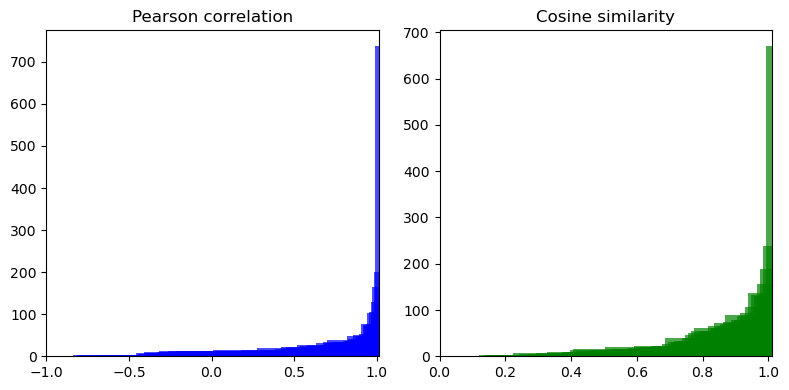

In [151]:
plotSimilarityHist(corrList,cosList)

## Run comprehensively
- Compile all the probablity dictionaries of card + subsets
- Run the correlation for all cards and subsets
- Track the correlation value for the same read across multiple subsets

In [7]:
probHash = makeAllReferenceHashDicts(keyCard,hpEdges,hpKeys_split)

Calculating for card= 9
There are  4 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Creating a probability hash for 7-way subsets
Creating a probability hash for 8-way subsets
Calculating for card= 8
There are  182 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Creating a probability hash for 7-way subsets
Calculating for card= 7
There are  3464 reads
Creating a probability hash for 2-way subsets
Creating a probability hash for 3-way subsets
Creating a probability hash for 4-way subsets
Creating a probability hash for 5-way subsets
Creating a probability hash for 6-way subsets
Calculating for card= 6
There are  350

In [15]:
warnings.filterwarnings('ignore')
statsForAllReads(keyCard,probHash,10,False,False,1)

Calculating for card= 9
There are  4 reads
Calculating stats for 4 reads
Writing output
Calculating for card= 8
There are  182 reads
Calculating stats for 10 reads
Writing output
Calculating for card= 7
There are  3464 reads
Calculating stats for 10 reads
Writing output
Calculating for card= 6
There are  35016 reads
Calculating stats for 10 reads
Writing output
Calculating for card= 5
There are  173475 reads
Calculating stats for 10 reads
Writing output
Calculating for card= 4
There are  295052 reads
Calculating stats for 10 reads
Writing output
Calculating for card= 3
There are  107671 reads
Calculating stats for 10 reads
Writing output


()

In [33]:
print(cosStats)

print(corrStats)

       7Sub2     7Sub3     7Sub4     7Sub5     7Sub6  Edge_ix
0   0.984967  0.984337  0.958828  0.899602  0.901983   184337
1   0.963441  0.999198  0.929691  0.846756  0.909815   477541
2   0.957376  0.948172  0.926637  0.881018  0.713547   589244
3   0.983909  0.980485  0.940576  0.619321  0.975192   573555
4   0.980278  0.993635  0.982445  0.913942  0.802473   110035
5   0.992128  0.990152  0.816639  0.811413  0.870221   299111
6   0.979113  0.748708  0.976435  0.721188  0.901934   167957
7   0.987276  0.923596  0.757757  0.671487  0.504735   440477
8   0.967781  0.877912  0.864318  0.958006  0.779403   572513
9   0.993851  0.990969  0.875365  0.913412  0.816519   423901
10  0.993866  0.919707  0.973547  0.622746  0.672570   432196
11  0.975614  0.906791  0.632221  0.964473  0.607891   518011
12  0.935555  0.964932  0.805399  0.440953  0.968235   373457
13  0.966598  0.897410  0.831742  0.949606  0.944499   582177
14  0.963659  0.941016  0.923515  0.805039  0.792386   256871
15  0.99

## Comparing reads from wasserstein versus cosine similarity

In [59]:
outDir = f'{dataDir}{runDir}dfs_sample2_7kChains_600_750_3/'
card = 5
coSimFile = pd.read_csv(f'{outDir}cosineSim_card{card}.csv',sep = "\t")
wDistFile = pd.read_csv(f'{outDir}wDist_card{card}.csv',sep = "\t")
eDistFile = pd.read_csv(f'{outDir}eDist_card{card}.csv',sep = "\t")
empDistFile = pd.read_csv(f'{outDir}empDist_card{card}.csv',sep = "\t")

In [56]:
# ## had to do again bc I messed up teh filtering
# summaryWDist = wDistFile.iloc[0:2500,].filter(like="Sub").agg((np.mean,np.std),axis = 1)
# wdistCutoff = getCutoff(summaryWDist,100 - 25)
# wStatus = [1 if x else 0 for x in (summaryWDist['mean'] >= wdistCutoff)]

In [3]:
print(coSimFile.head())

print(wDistFile.head())

      5Sub2     5Sub3     5Sub4  Edge_ix  Status
0  0.987553  0.590849  0.956803  1191563       1
1  0.993616  0.979976  0.925236  1941579       0
2  0.944668  0.983638  0.794055  2413086       0
3  0.959384  0.999758  0.857801   414909       0
4  0.863999  0.860552  0.738018  2568266       1
      5Sub2     5Sub3     5Sub4  Edge_ix  Status
0  0.049984  0.076433  0.083931  1191563       0
1  0.032287  0.078607  0.077271  1941579       0
2  0.071829  0.043301  0.147902  2413086       0
3  0.095571  0.006167  0.087322   414909       0
4  0.053350  0.030711  0.160149  2568266       0


In [4]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "CoSim only" if v1 == 1 else "WDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(coSimFile['Status'][0:2500], wDistFile['Status'][0:2500])]

Text(0.5, 0.98, '5Sub4')

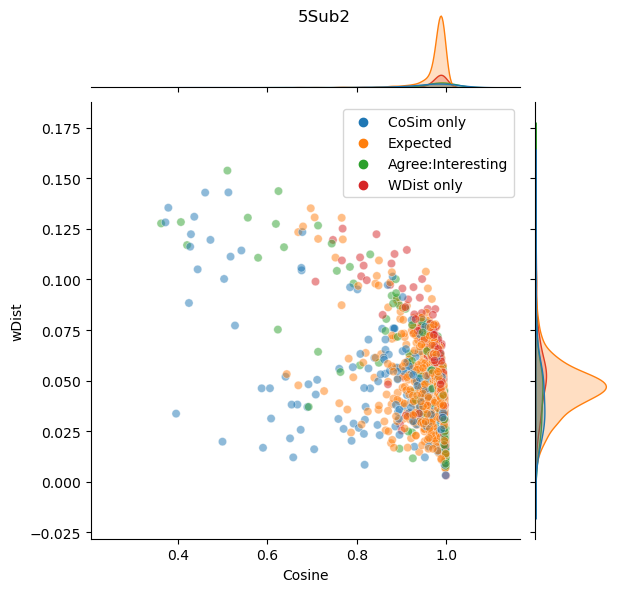

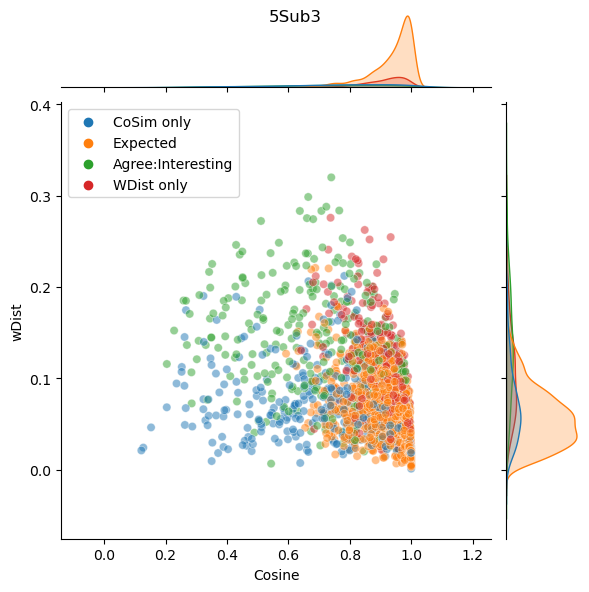

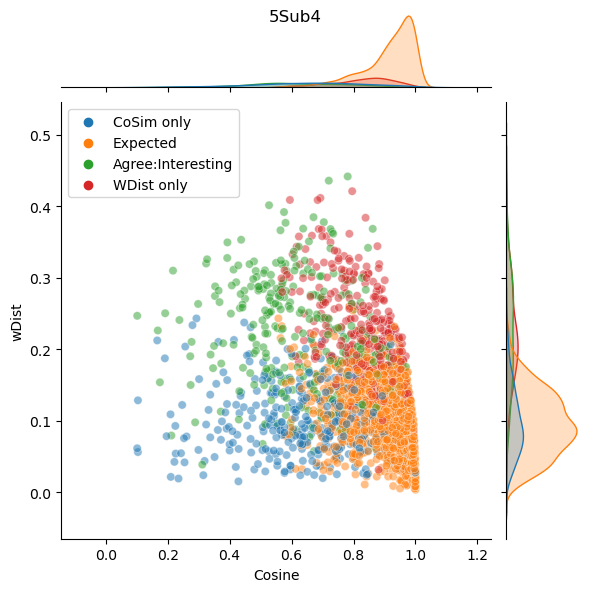

In [5]:
#fig, axes = plt.subplots(1, 2, figsize=(8, 4))

#plt.figure(figsize=(8, 4))
cos = coSimFile['5Sub2'][0:2500]
wDist = wDistFile['5Sub2'][0:2500]
j1 = sns.jointplot(x=cos, y=wDist, kind="scatter", hue=agreement_status, alpha = 0.5)
j1.set_axis_labels('Cosine', 'wDist', fontsize=10)
j1.fig.suptitle("5Sub2")
#axes[0].set_title('5Sub2')

cos = coSimFile['5Sub3'][0:2500]
wDist = wDistFile['5Sub3'][0:2500]
j2 = sns.jointplot(x=cos, y=wDist, kind="scatter", hue=agreement_status, alpha = 0.5)
j2.set_axis_labels('Cosine', 'wDist', fontsize=10)
j2.fig.suptitle("5Sub3")
#axes[1].set_title('5Sub3')

cos = coSimFile['5Sub4'][0:2500]
wDist = wDistFile['5Sub4'][0:2500]
j3 = sns.jointplot(x=cos, y=wDist, kind="scatter", hue=agreement_status, alpha = 0.5)
j3.set_axis_labels('Cosine', 'wDist', fontsize=10)
j3.fig.suptitle("5Sub4")
# plt.tight_layout()
# plt.show()

## empDist versus cosine similarity

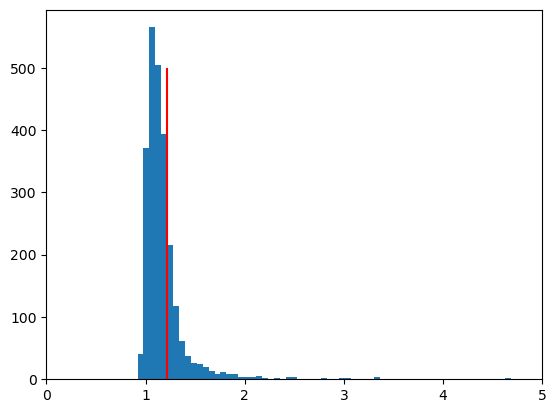

In [62]:
summary_empDist = empDistFile.iloc[0:2500].filter(like="Sub").agg((np.mean,np.std),axis = 1)
empdistCutoff = getCutoff(summary_empDist,75)
p = plt.hist(summary_empDist['mean'],bins=500)
plt.xlim(0,5)
plt.vlines(empdistCutoff, ymin = 0, ymax=500,colors="red")
plt.show()
empStatus = [1 if x else 0 for x in (summary_empDist['mean'] >= empdistCutoff)]

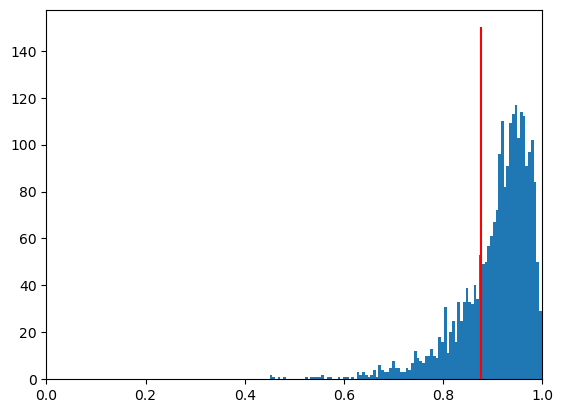

In [61]:
summary_cos = coSimFile.iloc[0:2500].filter(like="Sub").agg((np.mean,np.std),axis = 1)
cosCutoff = getCutoff(summary_cos,25)
p = plt.hist(summary_cos['mean'],bins=100)
plt.xlim(0,1)
plt.vlines(cosCutoff, ymin = 0, ymax=150,colors="red")
plt.show()
cosStatus = [1 if x else 0 for x in (summary_cos['mean'] <= cosCutoff)]

In [64]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "CoSim only" if v1 == 1 else "empDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(cosStatus, empStatus)]

Text(0.5, 0.98, '5Sub4')

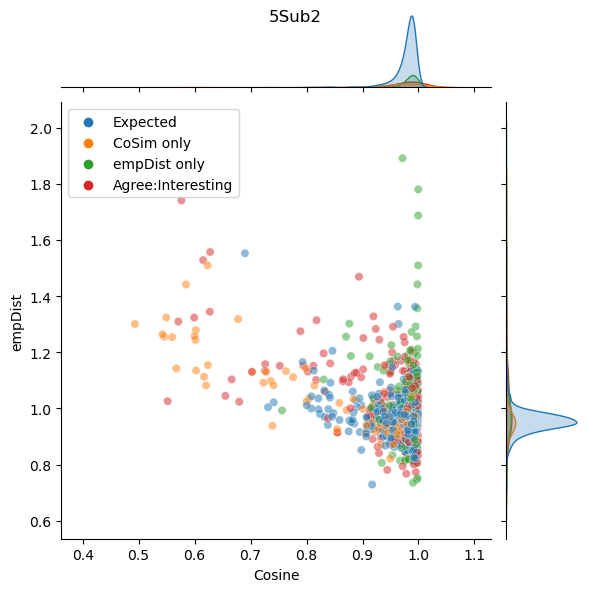

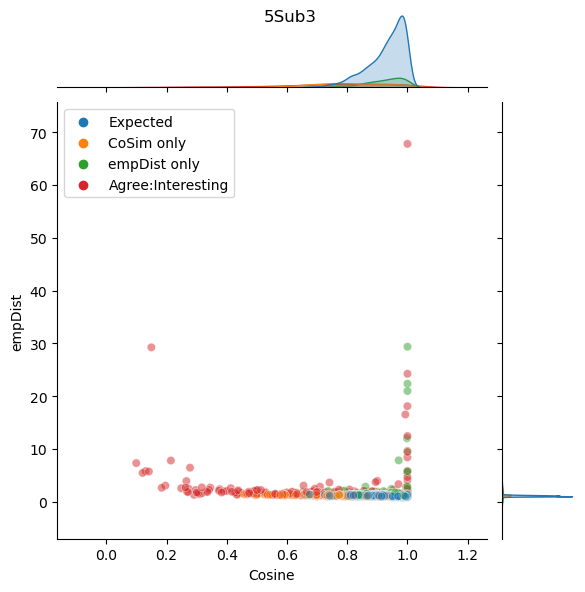

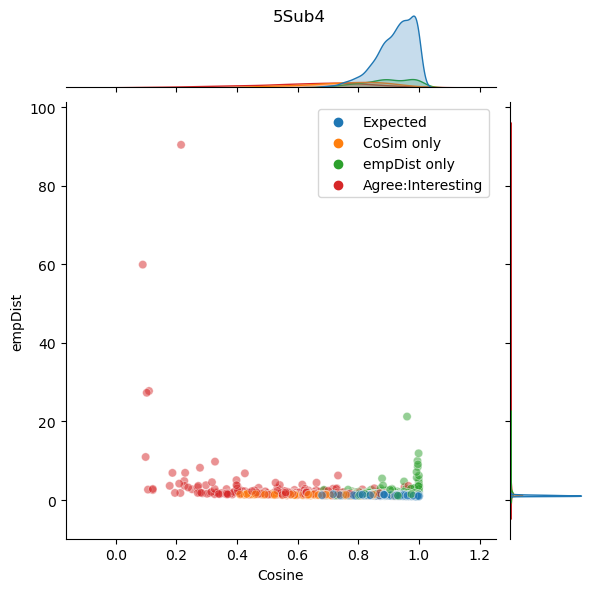

In [65]:
#fig, axes = plt.subplots(1, 2, figsize=(8, 4))

legend_order = ["Expected","CoSim only", "empDist only","Agree:Interesting"]

#plt.figure(figsize=(8, 4))
cos = coSimFile['5Sub2'][0:2500]
empDist = empDistFile['5Sub2'][0:2500]
j1 = sns.jointplot(x=cos, y=empDist, kind="scatter", hue=agreement_status, hue_order=legend_order, alpha = 0.5)
j1.set_axis_labels('Cosine', 'empDist', fontsize=10)
j1.fig.suptitle("5Sub2")
#axes[0].set_title('5Sub2')

cos = coSimFile['5Sub3'][0:2500]
empDist = empDistFile['5Sub3'][0:2500]
j2 = sns.jointplot(x=cos, y=empDist, kind="scatter", hue=agreement_status,hue_order=legend_order, alpha = 0.5)
j2.set_axis_labels('Cosine', 'empDist', fontsize=10)
j2.fig.suptitle("5Sub3")
#axes[1].set_title('5Sub3')

cos = coSimFile['5Sub4'][0:2500]
empDist = empDistFile['5Sub4'][0:2500]
j3 = sns.jointplot(x=cos, y=empDist, kind="scatter", hue=agreement_status, hue_order=legend_order, alpha = 0.5)
j3.set_axis_labels('Cosine', 'empDist', fontsize=10)
j3.fig.suptitle("5Sub4")
# plt.tight_layout()
# plt.show()

## empDist versus energy distance

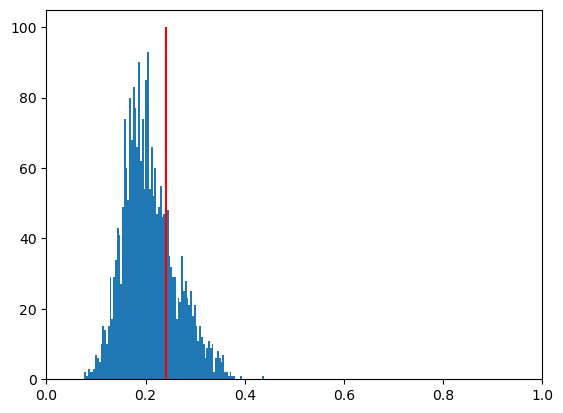

In [45]:
summary_eDist = eDistFile.iloc[0:2500].filter(like="Sub").agg((np.mean,np.std),axis = 1)
edistCutoff = getCutoff(summary_eDist,75)
p = plt.hist(summary_eDist['mean'],bins=100)
plt.xlim(0,1)
plt.vlines(edistCutoff, ymin = 0, ymax=100,colors="red")
plt.show()
edistStatus = [1 if x else 0 for x in (summary_eDist['mean'] >= edistCutoff)]

In [54]:
agreement_status = ["Agree:Interesting" if v1 == 1 and v2 == 1 else 
                    "Energy dist only" if v1 == 1 else "empDist only" if v2 == 1 
                    else "Expected" for 
                    v1, v2 in zip(edistStatus, empStatus)]

Text(0.5, 0.98, '5Sub4')

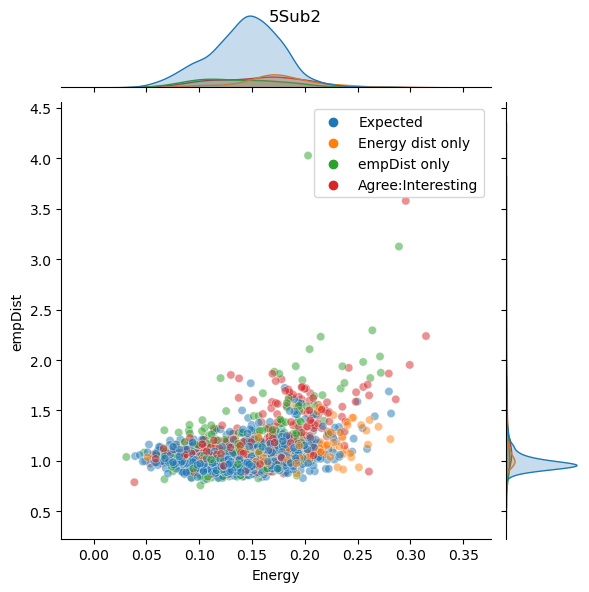

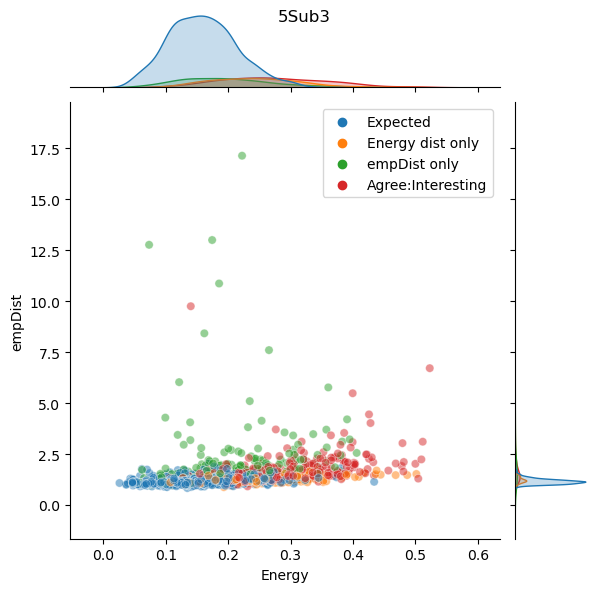

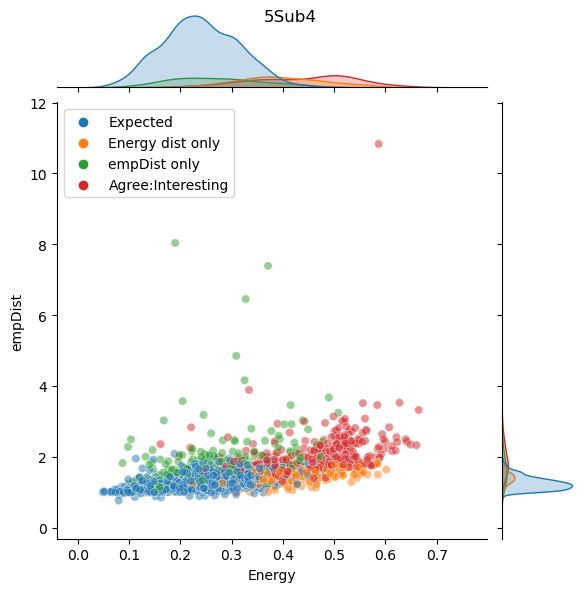

In [56]:
#fig, axes = plt.subplots(1, 2, figsize=(8, 4))

legend_order = ["Expected","Energy dist only", "empDist only","Agree:Interesting"]

#plt.figure(figsize=(8, 4))
edist = eDistFile['5Sub2'][0:2500]
empDist = empDistFile['5Sub2'][0:2500]
j1 = sns.jointplot(x=edist, y=empDist, kind="scatter", hue=agreement_status, hue_order=legend_order,alpha = 0.5)
j1.set_axis_labels('Energy', 'empDist', fontsize=10)
j1.fig.suptitle("5Sub2")
#axes[0].set_title('5Sub2')

edist = eDistFile['5Sub3'][0:2500]
empDist = empDistFile['5Sub3'][0:2500]
j2 = sns.jointplot(x=edist, y=empDist, kind="scatter", hue=agreement_status, hue_order=legend_order,alpha = 0.5)
j2.set_axis_labels('Energy', 'empDist', fontsize=10)
j2.fig.suptitle("5Sub3")
#axes[1].set_title('5Sub3')

edist = eDistFile['5Sub4'][0:2500]
empDist = empDistFile['5Sub4'][0:2500]
j3 = sns.jointplot(x=edist, y=empDist, kind="scatter", hue=agreement_status, hue_order=legend_order, alpha = 0.5)
j3.set_axis_labels('Energy', 'empDist', fontsize=10)
j3.fig.suptitle("5Sub4")
# plt.tight_layout()
# plt.show()

## Add edge weights for pruning short range interactions

## Try a different similarity mesaurement statistic

In [104]:
## test
print(len(hpKeys))
ix = 612701
print(hpKeys[ix])
readDict = makeNWayDict(ix,hpEdges,hpKeys_split,2)
readPercs = getProbabilitiesByDist(readDict)
print(readPercs)
print(readDict)
probVals = [probHash['5sub2'][k] for k in readDict.keys()]
print(probVals)
newProbs = [i/sum(probVals) for i in probVals]


619813
Bin150:154_Bin190:194_Bin375:379_Bin380:384_Bin440:444
Total= 113124
[0.050422545171670025, 0.04255507231003147, 0.03207984158975991, 0.00754923800431385, 0.04834517874191153, 0.03237155687564089, 0.012057565149747181, 0.7237986634135992, 0.027536155015734944, 0.023284183727590963]
defaultdict(<class 'int'>, {8: 5704, 45: 4814, 46: 3629, 58: 854, 37: 5469, 38: 3662, 50: 1364, 1: 81879, 13: 3115, 12: 2634})
[0.017324726905452524, 0.001217563224616202, 0.0011897019823003435, 0.0004986547173800921, 0.0021127887011871006, 0.0018813328167830417, 0.0008233973664465296, 0.5902426087456567, 0.009540648152265373, 0.010091312022003517]


Comparing -------------
Slope for observed: -0.5962235652538399
Slope for expected: -0.41443870342104744
Wass dist: 0.04116607420646516
Cosine similarity: 0.993417097085771


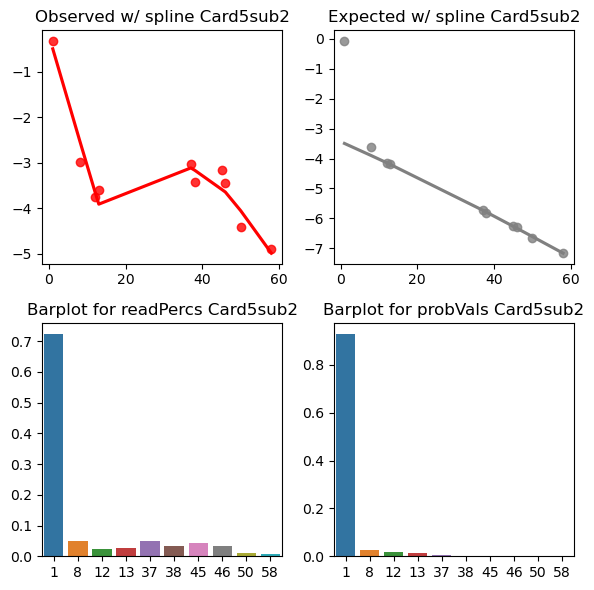

In [105]:
makeSanityCheckPlotsPerRead(readDict, readPercs, newProbs,5,2)

In [108]:
o = np.array(readPercs)
e = np.array(newProbs)

print(o)
print(e)

print(o/e)

obsOverExp = o/e
print("Obs over expected mean:", obsOverExp.mean())

print("Energy dist:", energy_distance(readPercs,newProbs))


[0.05042255 0.04255507 0.03207984 0.00754924 0.04834518 0.03237156
 0.01205757 0.72379866 0.02753616 0.02328418]
[2.72863546e-02 1.91765574e-03 1.87377443e-03 7.85378583e-04
 3.32763120e-03 2.96308939e-03 1.29684656e-03 9.29629034e-01
 1.50264711e-02 1.58937639e-02]
[ 1.84790331 22.19119495 17.12043945  9.612228   14.5284065  10.9249343
  9.2976035   0.7785887   1.83250976  1.46498865]
Obs over expected mean: 8.95987971275306
Energy dist: 0.15355826547574036
